# Text Classification With Tensorflow

In this project , we will work with IMDB dataset and perform sentiment analysis on tensorflow.

In [4]:
import matplotlib.pyplot as plt 
import os
import re
import shutil
import string
import tensorflow as tf    

from tensorflow.keras import layers
from tensorflow.keras import losses 
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## Sentiment Analysis 

This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem.

Lets download the dataset.

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclIMDB_v1", url, untar=True, cache_dir='.', cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset),'aclIMDB')

84131840/84125825 [==============================] - 123s 1us/step


In [6]:
# check the folder structure 

os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [7]:
# specifying the train files

train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

The aclImdb/train/pos and aclImdb/train/neg directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## Loading the dataset

We will load the data from the disk and prepare the data into a suitable format. We will use text_dataset_from_directory utility , which expects the dataset directory in a particular manner where there will be a positive review folder and a negative review folder. 

main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt


As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

## Train , test and validation split

The dataset is only missing the validation set. We wiil do it now.

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclIMDB/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Lets print some of the rows in the train data.

In [12]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

### Validation Set 

We created a training set of 20000 records. Now we will create a validation set on the rest 5000 records 

In [13]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclIMDB/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory('aclIMDB/test', batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful preprocessing.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

In [16]:
# custom function to remove htmls

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
    '[%s]' % re.escape(string.punctuation),'')

## Vectorization 

Next, you will create a TextVectorization layer. you will use this layer to standardize, tokenize, and vectorize our data. You set the output_mode to int to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.

In [17]:
max_features = 10000
sequence_length = 250 

vectorization_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

## New gotcha 

Next, you will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [18]:
# make a text only dataset (without labels), then call adapt
# I dont know how the model would train the data without labels but lets see 

train_text = raw_train_ds.map(lambda x, y: x)
vectorization_layer.adapt(train_text) 

This is deep learning thing is a real experimentation stuff. We make layers then we do things to those layers or we dont etc. 

Let's create a function to see the result of using this layer to preprocess some data.




In [19]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorization_layer(text), label 

In [20]:
# retrieve a batch of 32 reviews and labels from the dataset

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]

print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized Review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [21]:
print("1287 --->", vectorization_layer.get_vocabulary()[1287])

print('Vocabulary size: {}'.format(len(vectorization_layer.get_vocabulary())))

1287 ---> silent
Vocabulary size: 10000


See the vocab size is 10000 : the size that we mentioned in the model. 

Finally for the preprocessing step we will use the TextVectorization layer on the train,test and validation sets.

In [22]:
train_ds = raw_train_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

## Configuring the dataset for performance 

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create The Model



In [28]:
embedding_dim = 16

model = tf.keras.Sequential(
    [
        layers.Embedding(max_features + 1, embedding_dim),
        layers.Dropout(0.2),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.2),
        layers.Dense(1)
    ]
)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


## Loss function and optimizer 

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use losses.BinaryCrossentropy loss function.

In [31]:
model.compile(loss = losses.BinaryCrossentropy(from_logits = True), optimizer = 'adam', metrics = tf.metrics.BinaryAccuracy(threshold = 0.0))

## Training the model 



In [32]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds,epochs=epochs)

Epoch 1/10
625/625 [==============================] - 324s 518ms/step - loss: 0.6633 - binary_accuracy: 0.6916 - val_loss: 0.6138 - val_binary_accuracy: 0.7752
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 0.5482 - binary_accuracy: 0.8009 - val_loss: 0.4981 - val_binary_accuracy: 0.8220
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4446 - binary_accuracy: 0.8462 - val_loss: 0.4202 - val_binary_accuracy: 0.8474
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3791 - binary_accuracy: 0.8662 - val_loss: 0.3740 - val_binary_accuracy: 0.8600
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3358 - binary_accuracy: 0.8792 - val_loss: 0.3452 - val_binary_accuracy: 0.8668
Epoch 6/10
625/625 [==============================] - 8s 12ms/step - loss: 0.3055 - binary_accuracy: 0.8884 - val_loss: 0.3259 - val_binary_accuracy: 0.8722
Epoch 7/10
625/625 [==============================] - 7

In [33]:
## Evaluation 
loss ,accuracy = model.evaluate(test_ds)

print("Loss:", loss)
print("Accuracy:", accuracy)

782/782 [==============================] - 319s 408ms/step - loss: 0.3099 - binary_accuracy: 0.8738
Loss: 0.3098568618297577
Accuracy: 0.8737599849700928


## Creating a plot of the training and loss details 

model.fit() returns a History object that contains a dictionary with everything that happened during training:

In [34]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

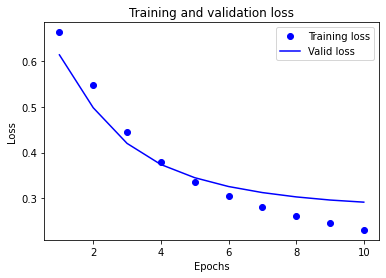

In [35]:
# plotting the metrics 

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss') # blue dot
plt.plot(epochs, val_loss, 'b', label = 'Valid loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Seems like that the loss in validation was a bit higher than the training. Lets measure the accuracy 

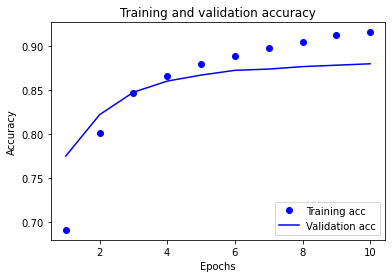

In [37]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

## Exporting the layer 

In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [40]:
export_model = tf.keras.Sequential([
  vectorization_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 257s 329ms/step - loss: 0.3099 - accuracy: 0.8738
0.8737599849700928


## Testing with new data 

Lets see how the model performs on the a new set. Here, towards 1 is positive and negative on otherwise.

In [41]:
examples = [
    "The movie was great",
    "Is this a movie ?",
    "Quality is not cutting it"


]

export_model.predict(examples)

array([[0.6419346 ],
       [0.5437671 ],
       [0.49374238]], dtype=float32)